In [292]:
import pandas as pd
import pmdarima as pm
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro

In [293]:
df = pd.read_csv("covid-hospit-2023-03-31-18h01.csv", sep = ';')
df.head()

,dep,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,01,0,2020-03-18,2,0,NaN,NaN,NaN,1,0
1,01,1,2020-03-18,1,0,NaN,NaN,NaN,1,0
2,01,2,2020-03-18,1,0,NaN,NaN,NaN,0,0
3,02,0,2020-03-18,41,10,NaN,NaN,NaN,18,11
4,02,1,2020-03-18,19,4,NaN,NaN,NaN,11,6


In [294]:
df = df.drop(["dep","sexe","rea","HospConv","SSR_USLD","autres","rad","dc"],axis=1)

In [295]:
df = df.dropna()
df = df.drop_duplicates()
df = df.loc[(df!=0).any(axis=1)]
df

,jour,hosp
0,2020-03-18,2
1,2020-03-18,1
3,2020-03-18,41
4,2020-03-18,19
5,2020-03-18,22
...,...,...
338223,2023-03-31,252
338224,2023-03-31,317
338225,2023-03-31,343
338226,2023-03-31,144


In [296]:
df["jour"] = pd.to_datetime(df["jour"])
df = df.set_index("jour")

In [297]:
df = df.groupby(pd.Grouper(freq='D')).sum()
df.shape

(1109, 1)

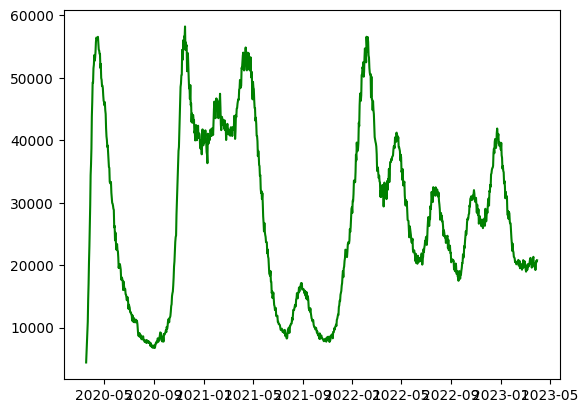

In [298]:
plt.plot(df,color="green")
plt.show()

In [299]:
adfuller(df)

(-3.157110581401882,
 0.02260542823028116,
 19,
 1089,
 {'1%': -3.436369082756128,
  '5%': -2.8641976875421524,
  '10%': -2.5681850407995137},
 17857.397480977306)

In [300]:
differenced = df['hosp'].diff().dropna()
adfuller(differenced)

(-6.661637832237944,
 4.8305706446883085e-09,
 22,
 1085,
 {'1%': -3.436391325753478,
  '5%': -2.864207498909067,
  '10%': -2.5681902663042324},
 17847.463590323554)

p < 0.05 donc la série est stationnaire.

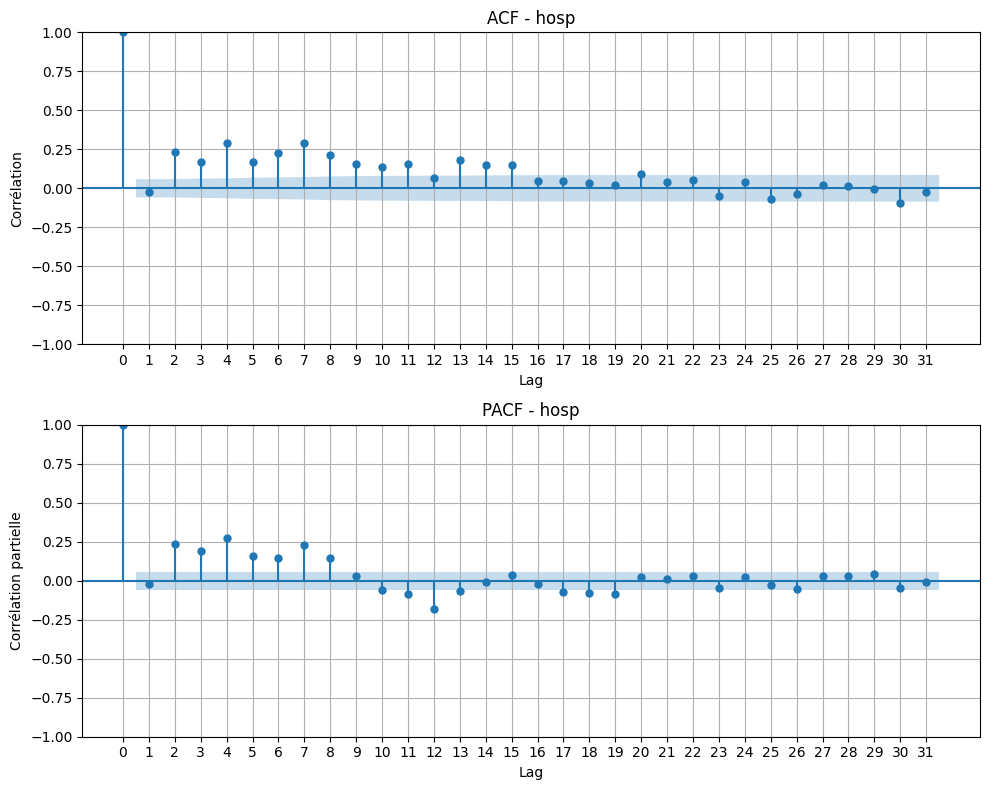

In [301]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(differenced, lags=31, zero=True, ax=ax1)
ax1.set_title('ACF - hosp')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

ax1.set_xticks(np.arange(0, 32, 1))

plot_pacf(differenced, lags=31, zero=True, ax=ax2)
ax2.set_title('PACF - hosp')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

ax2.set_xticks(np.arange(0, 32, 1))

plt.tight_layout()

plt.show()

p = 19, d = 1, q = 13

In [302]:
train_data = differenced[:-100]
test_data = differenced[-100:]
model = ARIMA(train_data, order=(19,1,13))
model_fit = model.fit()

C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [303]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   hosp   No. Observations:                 1008
Model:               ARIMA(19, 1, 13)   Log Likelihood               -8325.586
Date:                Fri, 14 Mar 2025   AIC                          16717.172
Time:                        10:25:28   BIC                          16879.358
Sample:                    03-19-2020   HQIC                         16778.793
                         - 12-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7800      1.885     -0.414      0.679      -4.475       2.915
ar.L2         -0.3234      2.877     -0.112      0.910      -5.962       5.315
ar.L3         -0.1607      2.763     -0.058      0.9

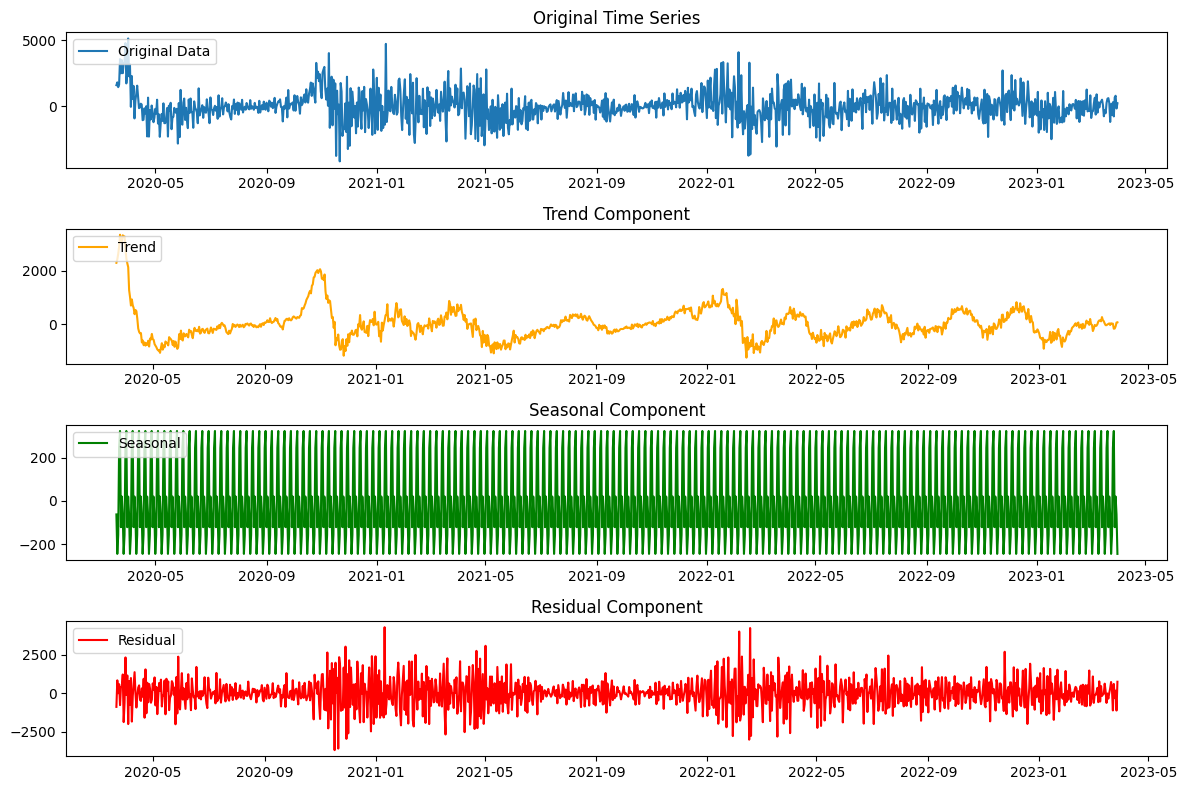

In [304]:
result = seasonal_decompose(differenced, model='additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(differenced, label='Original Data')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

In [305]:
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

test_mse = mean_squared_error(test_data, predictions)
print(test_mse)

572921.3133209632


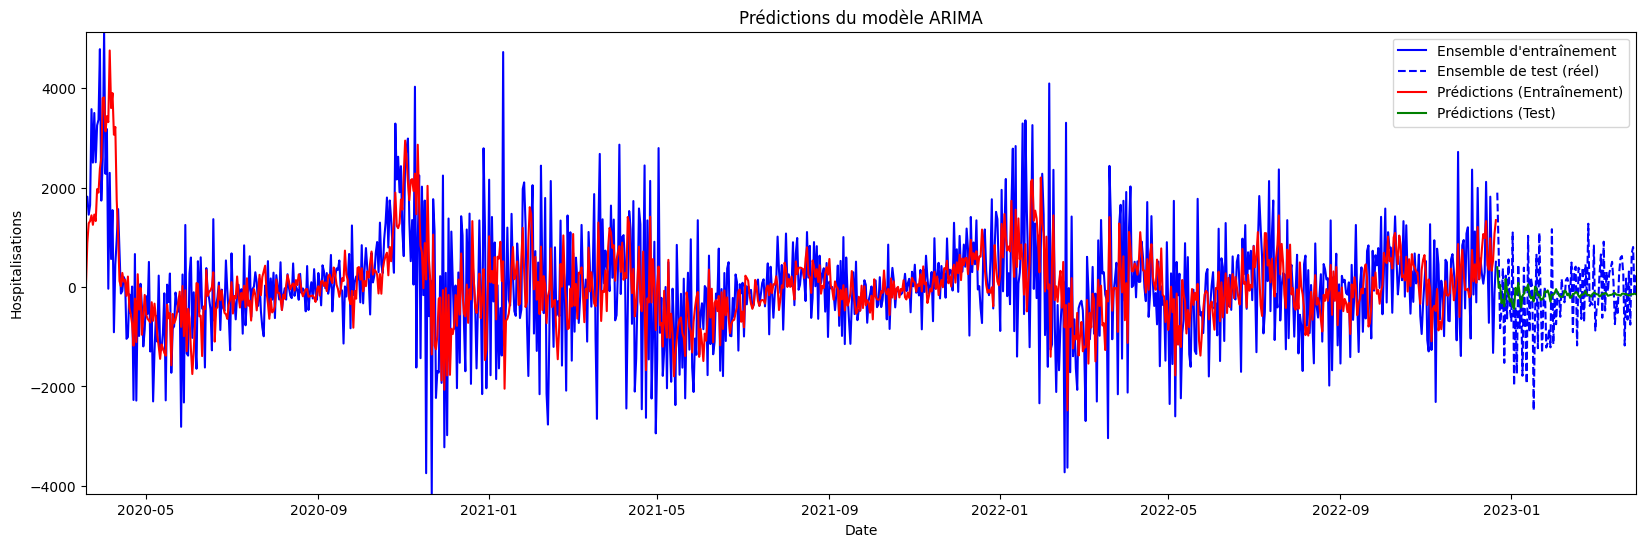

In [306]:

train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])


test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])


plt.figure(figsize=(20, 6))
plt.plot(train_data.index, train_data.values, label='Ensemble d\'entraînement', color='blue')
plt.plot(test_data.index, test_data.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(train_data.index, train_predictions, label='Prédictions (Entraînement)', color='red')
plt.plot(test_data.index, test_predictions, label='Prédictions (Test)', color='green')


plt.xlim(train_data.index[0], test_data.index[-1])
plt.ylim(min(train_data.min(), test_data.min()), max(train_data.max(), test_data.max()))

plt.xlabel('Date')
plt.ylabel('Hospitalisations')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

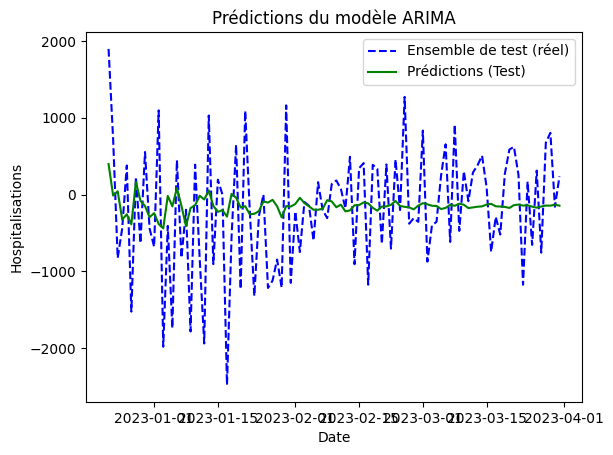

In [307]:
plt.plot(test_data.index, test_data.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(test_data.index, test_predictions, label='Prédictions (Test)', color='green')
plt.xlabel('Date')
plt.ylabel('Hospitalisations')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

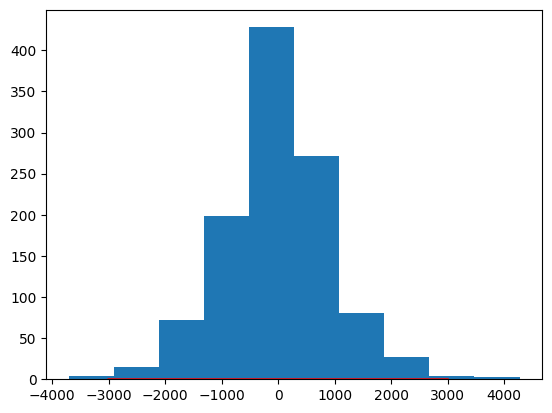

In [308]:
mean = np.mean(residual)
std = np.std(residual)

x_min = -3000
x_max = 3000
x = np.linspace(x_min, x_max, 100000)
y = scipy.stats.norm.pdf(x,mean,std)
plt.plot(x,y, color='red')

plt.hist(residual)
plt.show()

In [309]:
train_data = differenced[:-200]
test_data = differenced[-200:]

model2 = pm.auto_arima(train_data)
model2_fit = model2.fit(train_data)

print(model2.summary())

C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  908
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -7548.230
Date:                Fri, 14 Mar 2025   AIC                          15116.461
Time:                        10:25:47   BIC                          15164.573
Sample:                    03-19-2020   HQIC                         15134.832
                         - 09-12-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8799      0.041     21.438      0.000       0.799       0.960
ar.L2         -0.0355      0.048     -0.744      0.457      -0.129       0.058
ar.L3          0.9112      0.047     19.224      0.0

len(predictions2) = 10 alors que len(test_data) = 100 donc mse impossible.

In [342]:
predictions2 = model2_fit.predict(start=test_data.index[0], end=test_data.index[-1])
test_mse = mean_squared_error(test_data[:10], predictions2)
print(test_mse)

448801.1119930522


C:\Users\cabro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


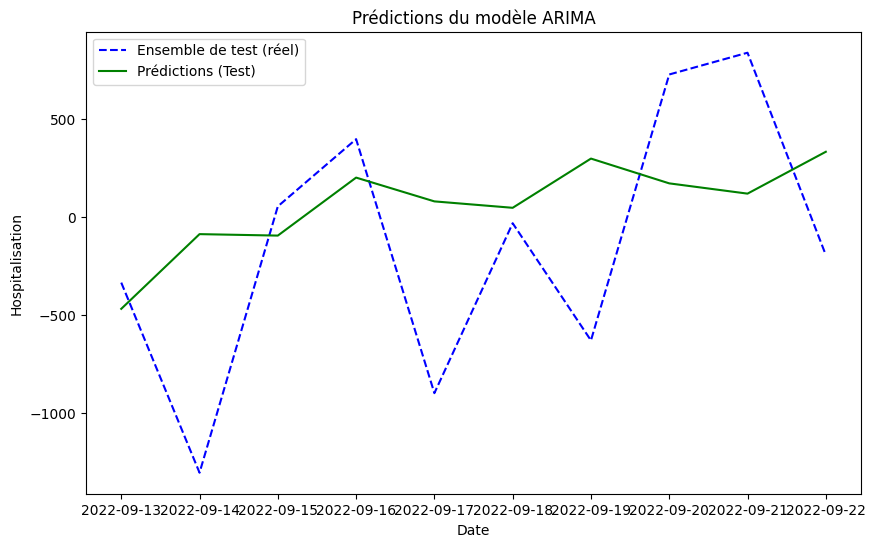

In [343]:
plt.figure(figsize=(10, 6))
plt.plot(test_data[:10].index, test_data[:10].values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(test_data[:10].index, predictions2, label='Prédictions (Test)', color='green')

plt.xlabel('Date')
plt.ylabel('Hospitalisation')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()